# **Problem Outline**

We have been given a dataset of news articles which is about propaganda detection. 

In the digital age, disinformation can spread very easily by any sources and has the capacity to reach a very wide audience. To advance a particular agenda, propaganda aims to inflence people's mindset. 

Training and Testing data is provided in a seperate files.

Use of additional tokens <BOS> and <EOS> which indicate the begin
ning and end of the span of text (within the sentence) which is actually annotated with the given propaganda

There are total 9 classes in the propoganda detection as follows:

1. flag waving

2. appeal to fear prejudice

3. causal simplification

4. doubt

5. exaggeration,minimisation

6. loaded language

7. name calling,labeling

8. repetition

9. not propaganda

The main tasks are as follows:

1. **Build and evaluate at least 2 approaches to classify whether a sentence contains propaganda or not.**

2. **Given a snippet or span of text which is known to contain propaganda, build and evaluate at least 2 approaches to classifying the propaganda technique which has been used.**

We will use following approach in this report.

1. **Span Identification**

**Pretrained large language models - BERT Uncased**

**Neural Language Model - LSTM(Long Short-Term Memory Neural Network)**


2. **Technique Classification**

**Pretrained large language models - BERT Cased**

**Glove( Global Vectors for Word Representation) and Neural Language Model - Bidirectional LSTM**

In [6]:
from google.colab import drive    #Connecting to google drive to access data
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Installing all the necessary libraries
!pip install transformers
!pip install tensorboardx 
!pip install tensorflow
!pip install np_utils
!pip install --upgrade tensorflow
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 5.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56460 sha256=7df0327fd301868eb0f029624928ffef60b5e049722288d1a06b0bda18ce4227
  Stored

In [177]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer
from transformers import BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm 
import re
from simpletransformers.classification import ClassificationModel
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import RobertaModel
from transformers import RobertaTokenizer
from plotly.offline import iplot
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import os,random,math
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Saving the location of file in a variable
PROPAGANDA_DATA_DIR="/content/drive/MyDrive/Sussex/SEM_2/Advance_NLP/Assignment/propaganda_dataset_v2" #this needs to be the parent directory for the training corpus
TRAINING_FILE= "/content/drive/MyDrive/Sussex/SEM_2/Advance_NLP/Assignment/propaganda_dataset_v2/propaganda_train.tsv"
VALIDATION_FILE="/content/drive/MyDrive/Sussex/SEM_2/Advance_NLP/Assignment/propaganda_dataset_v2/propaganda_val.tsv"
filenames=os.listdir(PROPAGANDA_DATA_DIR)
n=len(filenames)
print("There are {} files in the training directory: {}".format(n,PROPAGANDA_DATA_DIR))

There are 6 files in the training directory: /content/drive/MyDrive/Sussex/SEM_2/Advance_NLP/Assignment/propaganda_dataset_v2


In [10]:
# Loading the Train data in a dataframe
train_df = pd.read_csv(TRAINING_FILE, sep="\t", header=0)
print(train_df.columns)
train_df.head()

Index(['label', 'tagged_in_context'], dtype='object')


,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [13]:
# Loading the Validation data in a dataframe
validation_df = pd.read_csv(VALIDATION_FILE, sep="\t", header=None, names=["label","tagged_in_context"])
print(validation_df.columns)
validation_df = validation_df.drop(0)
validation_df=validation_df.reset_index(drop=True)
validation_df.head()

Index(['label', 'tagged_in_context'], dtype='object')


,label,tagged_in_context
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...


In [14]:
"""
This function is used to get the general information about dataframe.
Like The number of columns, Unique Values in a colmn, Total Value count, Total Null, Shape, size and for describing basic statistics in a dataframe
"""
def general_info_dataframe(df,name="TRAIN DATA",column="label"):
  print(f"{name} Number of unique values",df[column].nunique())
  print("-----------------------------------------------------")
  print(f"{name} unique values",df[column].unique())
  print("-----------------------------------------------------")
  print(f"Occurance of propoganda techniques in {name}\n",df[column].value_counts())
  print("-----------------------------------------------------")
  print(f"{name} Total null",df.isnull().sum())
  print("-----------------------------------------------------")
  print(f"{name} SHAPE",df.shape)
  print("-----------------------------------------------------")
  print(f"{name} Size",df.size)
  print("-----------------------------------------------------")
  print(f"{name} Information:")
  print(df.info())
  print("-----------------------------------------------------")
  print(f"Describe {name}")
  print(df[column].describe().T)

In [15]:
"""
This function is used to plot the graph for dataframe and show the value counts for label
"""
def plot_graph(df,dict={},column="label",label="Label Counts",x_name="Count",y_name="Label"):
  # Count the occurrences of each label
  if len(dict)!=0:
    df[column] = df[column].replace(dict)
  count_number_of_occurence_of_value = df[column].value_counts()

  # Plot the counts as a horizontal bar graph
  axis_data = count_number_of_occurence_of_value.plot(kind='barh', rot=45, fontsize=10, figsize=(8, 6))

  # set the axis labels and title
  axis_data.set_xlabel(x_name)
  axis_data.set_ylabel(y_name)
  axis_data.set_title(label)

  # show the plot
  plt.show()

In [16]:
"""
This function is used to to filter the <BOS> <EOS> tags from the text

"""
import re

# defining regular expression pattern to match the text between <BOS> and <EOS> tags but here it will be considered as string
pattern = r'<BOS>(.+?)<EOS>'   

def extract_text_from_tags(row,column_name="tagged_in_context"): 
    match = re.search(pattern, row[column_name])
    if match:
        return match.group(1)
    else:
        return ''

In [17]:
"""
This function is used to plot the graph for mean length of characters in a given dataframe.
And also show the values in a dictionary.

"""
def mean_length_of_char_in_df(df,groupby_col="label",col="len_of_span",xlabel_name="Mean Length of Span in dataset"):
  axis_df = df.groupby(groupby_col)[col].mean().plot(kind='barh', rot=45, fontsize=10, figsize=(8, 6))
  axis_df.set_xlabel(xlabel_name)
  axis_df.grid(axis='x')
  plt.show()
  mean_dict = df.groupby(groupby_col)[col].mean().round(2).to_dict()
  print("Length for labels are as follows",mean_dict)


In [18]:
"""
This function is used to load the data for span identification task.
"""
def span_identification_df():
  print("Training Dataframe for Span Identification")
  train_df_si = train_df.copy(deep=True)
  # Below code of line replaces all other labels except not_propoganda label as propoganda
  train_df_si["label"] = train_df_si["label"].apply(lambda x: "not_propaganda" if x == "not_propaganda" else "propaganda") 
  train_df_si = train_df_si.rename(columns={'tagged_in_context': 'text'})           # Renaming the column 
  train_df_si = train_df_si.reindex(columns=['text', 'label'])                    # Reindexing the column
  print(train_df_si.head())
  print("----------------------------------------------------------------------------------------------------------------")
  print("Validation Dataframe for Span Identification")
  validation_df_si = validation_df.copy(deep=True)
  # Below code of line replaces all other labels except not_propoganda label as propoganda
  validation_df_si["label"] = validation_df_si["label"].apply(lambda x: "not_propaganda" if x == "not_propaganda" else "propaganda")
  validation_df_si = validation_df_si.rename(columns={'tagged_in_context': 'text'}) # Renaming the column 
  validation_df_si = validation_df_si.reindex(columns=['text', 'label'])            # Reindexing the column
  print(validation_df_si.head())
  print("----------------------------------------------------------------------------------------------------------------")
  labels = {'not_propaganda': 0,'propaganda': 1}     # Defining numbers instead of label name so that models can understand the data
  reverse_index = dict(enumerate(labels))
  print("reverse_index for Span Identification 2 Labels:\n",reverse_index)  # Mapping it back to original labels
  return train_df_si,validation_df_si,labels,reverse_index

In [19]:
"""
This function is used to load the data for technique classification task.
"""
def technique_classification_df():
  print("Training Dataframe for Technique Classification")
  train_df_tc = train_df.copy(deep=True)
  train_df_tc = train_df_tc.rename(columns={'tagged_in_context': 'text'})  # Renaming the column 
  train_df_tc = train_df_tc.reindex(columns=['text', 'label'])             # Reindexing the column
  train_df_tc = train_df_tc[train_df_tc['label'] != 'not_propaganda']      # Filtering all the rows where label is not_propoganda for training data
  print(train_df_tc.head())
  print("----------------------------------------------------------------------------------------------------------------")
  print("Validation Dataframe for Technique Classification")
  validation_df_tc = validation_df.copy(deep=True)
  validation_df_tc = validation_df_tc.rename(columns={'tagged_in_context': 'text'})     # Renaming the column 
  validation_df_tc = validation_df_tc.reindex(columns=['text', 'label'])                  # Reindexing the column
  validation_df_tc = validation_df_tc[validation_df_tc['label'] != 'not_propaganda']      # Filtering all the rows where label is not_propoganda for Validation data
  print(validation_df_tc.head())
  print("----------------------------------------------------------------------------------------------------------------")
  labels = {'appeal_to_fear_prejudice': 0,'causal_oversimplification': 1, 'doubt': 2, 'exaggeration,minimisation': 3,'flag_waving': 4,'loaded_language': 5, 'name_calling,labeling': 6,
 'repetition': 7}       # Defining numbers instead of label name so that models can understand the data
  reverse_index = dict(enumerate(labels))
  print("reverse_index for Technique Classification 8 Labels:\n",reverse_index)  # Mapping it back to original labels
  return train_df_tc,validation_df_tc,labels,reverse_index

In [83]:
"""
This function is used after model gives predictions to perform error analysis.
It returns the mean lengths of mismatched rows by grouping the labels together

"""
def calculate_mean_sentence_lengths(df):
    # Filter rows where label and prediction don't match
    mismatched_rows = df[df['label'] != df['prediction']]
    
    # Calculating the length of each sentence
    sentence_lengths = mismatched_rows['text'].apply(lambda x: len(x))
    
    # Group by prediction and calculate the mean sentence length
    grouped_lengths = sentence_lengths.groupby(mismatched_rows['prediction'])
    mean_lengths = grouped_lengths.mean()
    
    return mean_lengths

In [20]:
general_info_dataframe(train_df,name="TRAIN DATA",column="label")  # Understanding basic information for training data

TRAIN DATA Number of unique values 9
-----------------------------------------------------
TRAIN DATA unique values ['not_propaganda' 'flag_waving' 'loaded_language' 'doubt'
 'name_calling,labeling' 'appeal_to_fear_prejudice' 'repetition'
 'causal_oversimplification' 'exaggeration,minimisation']
-----------------------------------------------------
Occurance of propoganda techniques in TRAIN DATA
 not_propaganda               1191
exaggeration,minimisation     164
causal_oversimplification     158
name_calling,labeling         157
loaded_language               154
appeal_to_fear_prejudice      151
flag_waving                   148
repetition                    147
doubt                         144
Name: label, dtype: int64
-----------------------------------------------------
TRAIN DATA Total null label                0
tagged_in_context    0
dtype: int64
-----------------------------------------------------
TRAIN DATA SHAPE (2414, 2)
---------------------------------------------------

In [21]:
general_info_dataframe(validation_df,name="VALIDATION DATA",column="label") # Understanding basic information for validation data

VALIDATION DATA Number of unique values 9
-----------------------------------------------------
VALIDATION DATA unique values ['not_propaganda' 'causal_oversimplification' 'appeal_to_fear_prejudice'
 'repetition' 'name_calling,labeling' 'loaded_language' 'flag_waving'
 'doubt' 'exaggeration,minimisation']
-----------------------------------------------------
Occurance of propoganda techniques in VALIDATION DATA
 not_propaganda               301
appeal_to_fear_prejudice      43
flag_waving                   39
doubt                         38
loaded_language               37
repetition                    32
causal_oversimplification     31
name_calling,labeling         31
exaggeration,minimisation     28
Name: label, dtype: int64
-----------------------------------------------------
VALIDATION DATA Total null label                0
tagged_in_context    0
dtype: int64
-----------------------------------------------------
VALIDATION DATA SHAPE (580, 2)
------------------------------------

In [34]:
all_data = pd.concat([train_df, validation_df])       # Concatinating train and validayion data
all_data.head()

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [36]:
labels_dict = {'appeal_to_fear_prejudice': 0,'causal_oversimplification': 1, 'doubt': 2, 'exaggeration,minimisation': 3,'flag_waving': 4,'loaded_language': 5, 'name_calling,labeling': 6,
 'repetition': 7,'not_propaganda': 8}     # Converting Categorical labels to numerical form 

In [37]:
labels_as_name_dict={0: 'appeal_to_fear_prejudice',1:'causal_oversimplification',2:'doubt',3:'exaggeration,minimisation',4:'flag_waving',5:'loaded_language',
 6:'name_calling,labeling', 7:'repetition', 8:'not_propaganda'}

## **Exploratory Data Analysis**

In [38]:
general_info_dataframe(all_data,name="ALL DATA",column="label")  # exploring full data 

ALL DATA Number of unique values 9
-----------------------------------------------------
ALL DATA unique values ['not_propaganda' 'flag_waving' 'loaded_language' 'doubt'
 'name_calling,labeling' 'appeal_to_fear_prejudice' 'repetition'
 'causal_oversimplification' 'exaggeration,minimisation']
-----------------------------------------------------
Occurance of propoganda techniques in ALL DATA
 not_propaganda               1492
appeal_to_fear_prejudice      194
exaggeration,minimisation     192
loaded_language               191
causal_oversimplification     189
name_calling,labeling         188
flag_waving                   187
doubt                         182
repetition                    179
Name: label, dtype: int64
-----------------------------------------------------
ALL DATA Total null label                0
tagged_in_context    0
dtype: int64
-----------------------------------------------------
ALL DATA SHAPE (2994, 2)
-----------------------------------------------------
ALL DAT

In [39]:
all_data.head()

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [40]:
all_data["label"] = all_data["label"].map(labels_dict)    # Mapping Numerical labels instead of categorical labels.

In [41]:
all_data.head()

,label,tagged_in_context
0,8,"No, <BOS> he <EOS> will not be confirmed."
1,8,This declassification effort <BOS> won’t make ...
2,4,The Obama administration misled the <BOS> Amer...
3,8,“It looks like we’re capturing the demise of t...
4,8,"<BOS> Location: Westerville, Ohio <EOS>"


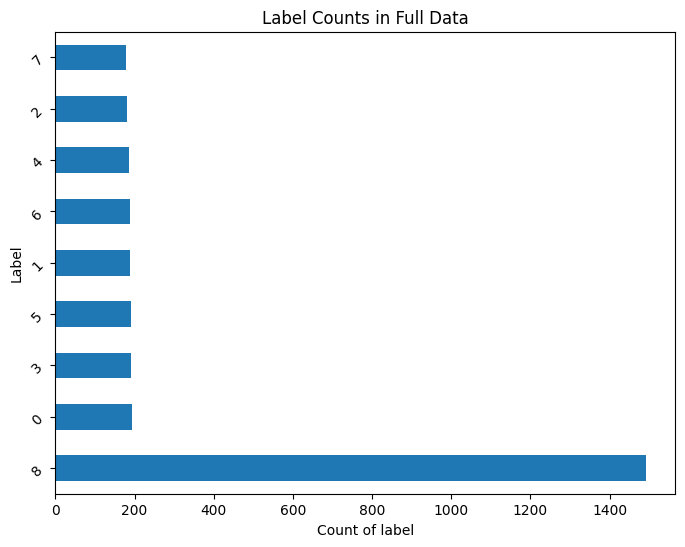

In [42]:
plot_graph(all_data,label="Label Counts in Full Data",x_name="Count of label",y_name="Label") # Plotting the Label count in Full data

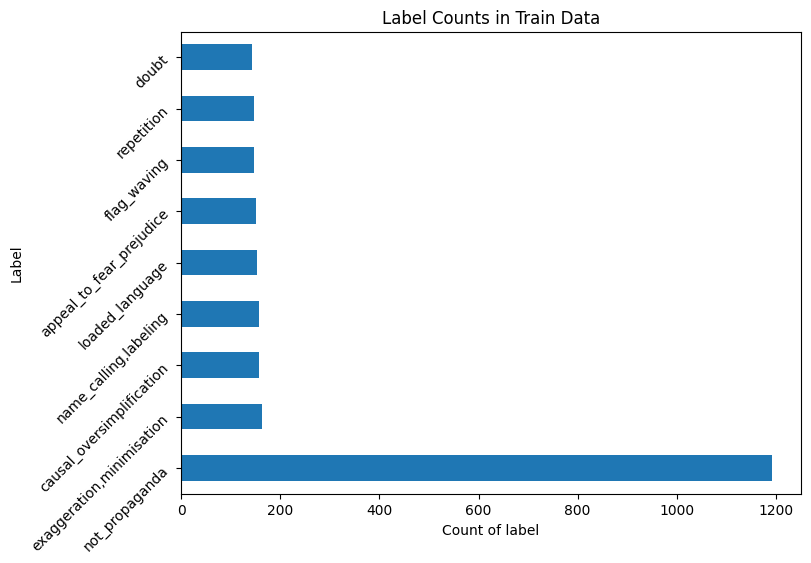

In [43]:
plot_graph(train_df,label="Label Counts in Train Data",x_name="Count of label",y_name="Label") # Plotting the Label count in Train data

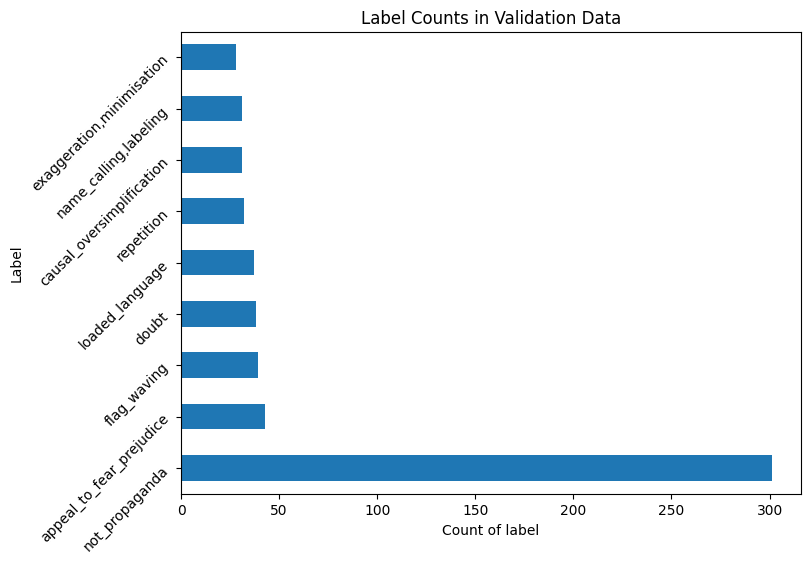

In [44]:
plot_graph(validation_df,label="Label Counts in Validation Data",x_name="Count of label",y_name="Label")# Plotting the Label count in Validation data

This demonstrates that the classes in our train and validate dataframe are balanced, which is crucial before training the classifier in order to prevent bias towards any certain classes.

**Length of text in full data**

In [45]:
all_data_copy = all_data.copy(deep=True)
all_data_copy['extracted_text_span'] = all_data_copy.apply(extract_text_from_tags, axis=1) # Filtering the data from tag
all_data_copy['len_of_span'] = all_data_copy['extracted_text_span'].apply(len)  # Applying length function to extracted_text_span
all_data_copy.head()

,label,tagged_in_context,extracted_text_span,len_of_span
0,8,"No, <BOS> he <EOS> will not be confirmed.",he,4
1,8,This declassification effort <BOS> won’t make ...,won’t make things any worse than they are for...,64
2,4,The Obama administration misled the <BOS> Amer...,American people,17
3,8,“It looks like we’re capturing the demise of t...,and,5
4,8,"<BOS> Location: Westerville, Ohio <EOS>","Location: Westerville, Ohio",29


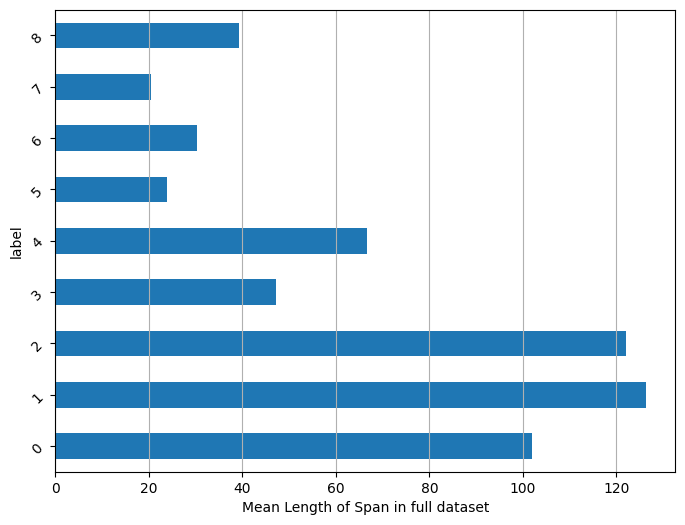

Length for labels are as follows {0: 101.98, 1: 126.35, 2: 121.98, 3: 47.11, 4: 66.58, 5: 23.78, 6: 30.39, 7: 20.47, 8: 39.33}


In [46]:
mean_length_of_char_in_df(all_data_copy,groupby_col="label",col="len_of_span",xlabel_name="Mean Length of Span in full dataset") #Mean Length of Span in full dataset

**Train Data Length of characters in propoganda technique detection**

In [50]:
train_df_copy = train_df.copy(deep=True)
train_df_copy['extracted_text_span'] = train_df_copy.apply(extract_text_from_tags, axis=1) # Filtering the data from tag
train_df_copy['len_of_span'] = train_df_copy['extracted_text_span'].apply(len)            # Applying length function to extracted_text_span
train_df_copy.head()

,label,tagged_in_context,extracted_text_span,len_of_span
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",he,4
1,not_propaganda,This declassification effort <BOS> won’t make ...,won’t make things any worse than they are for...,64
2,flag_waving,The Obama administration misled the <BOS> Amer...,American people,17
3,not_propaganda,“It looks like we’re capturing the demise of t...,and,5
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>","Location: Westerville, Ohio",29


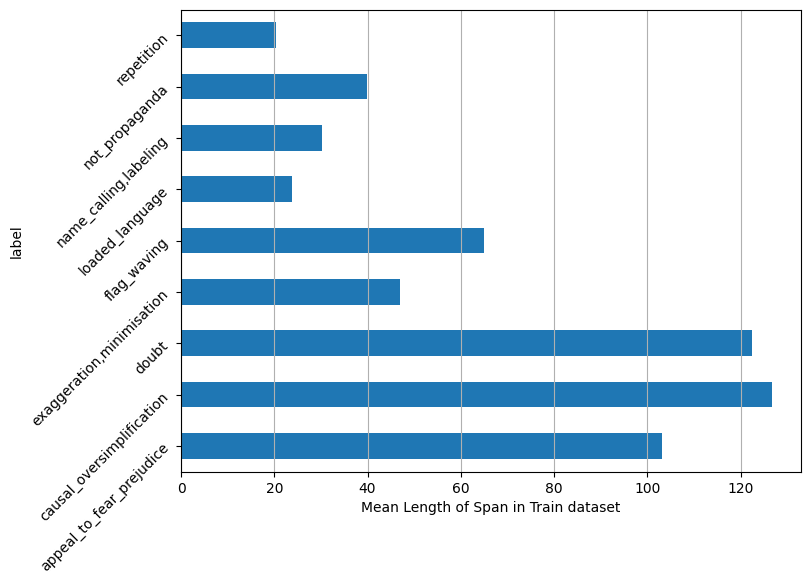

Length for labels are as follows {'appeal_to_fear_prejudice': 103.16, 'causal_oversimplification': 126.65, 'doubt': 122.56, 'exaggeration,minimisation': 46.98, 'flag_waving': 64.89, 'loaded_language': 23.79, 'name_calling,labeling': 30.29, 'not_propaganda': 39.78, 'repetition': 20.45}


In [51]:
mean_length_of_char_in_df(train_df_copy,groupby_col="label",col="len_of_span",xlabel_name="Mean Length of Span in Train dataset") #Mean Length of Span in Train dataset

**Validation Data Length of characters in propoganda technique detection**

In [52]:
validation_df_copy = validation_df.copy(deep=True)
validation_df_copy['extracted_text_span'] = validation_df_copy.apply(extract_text_from_tags, axis=1) # Filtering the data from tag
validation_df_copy['len_of_span'] = validation_df_copy['extracted_text_span'].apply(len)  # Applying length function to extracted_text_span
validation_df_copy.head()

,label,tagged_in_context,extracted_text_span,len_of_span
0,not_propaganda,"On average, between 300 and 600 infections are...",according to a UN estimate.,29
1,causal_oversimplification,Mostly because <BOS> the country would not las...,the country would not last long without an ou...,85
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,gets Earl Warren and Sen. Richard Russel to j...,139
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,You,5
4,repetition,It must be exacted from him directly in order ...,infidels,10


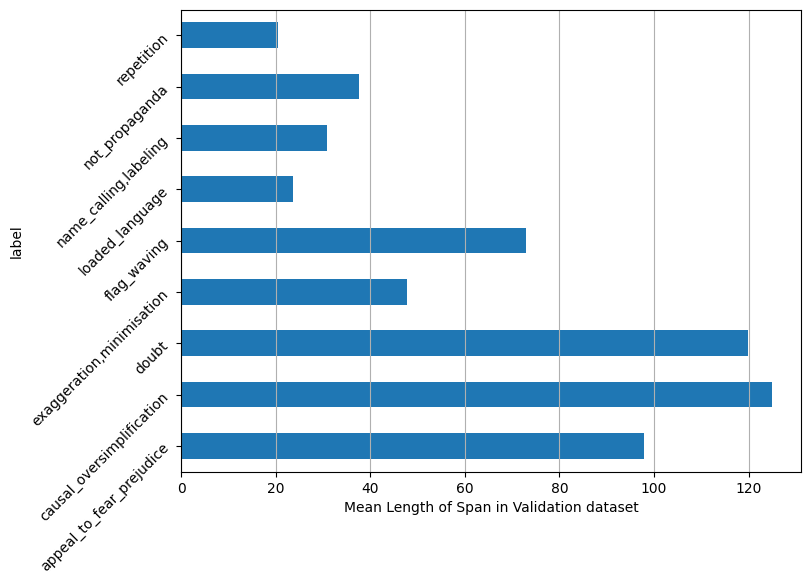

Length for labels are as follows {'appeal_to_fear_prejudice': 97.84, 'causal_oversimplification': 124.84, 'doubt': 119.79, 'exaggeration,minimisation': 47.86, 'flag_waving': 72.97, 'loaded_language': 23.76, 'name_calling,labeling': 30.87, 'not_propaganda': 37.54, 'repetition': 20.59}


In [53]:
mean_length_of_char_in_df(validation_df_copy,groupby_col="label",col="len_of_span",xlabel_name="Mean Length of Span in Validation dataset") #Mean Length of Span in Validation dataset

# **Span Identification Task**

In Span Identification task we have to identify whether the given text from article contains any propganda or not. Hence we will use the function span_identification_df to relabel all propoganda techniques as one label which is propoganda.

## **BERT Base Uncased Model For Span Identification Task**

BERT: A free machine learning framework for natural language processing (NLP) is called BERT. BERT uses the surrounding text to provide context in order to help computers understand the meaning of ambiguous words in text. With the help of question and answer datasets, the BERT framework can be adjusted after being pre-trained on text from Wikipedia.

Bidirectional Encoder Representations from Transformers, or BERT, is a deep learning model that is based on Transformers. In Transformers, each output element is connected to each input element, and the weightings between them are dynamically determined based upon their connection. This procedure is known as attention in NLP.

"Below functions evaluate, prepare_inputs and train and code for this section are taken from code available in the 6th Advance NLP Lab Sussex University."

(Source: https://canvas.sussex.ac.uk/courses/22822/pages/week-slash-topic-6-transfer-learning-with-large-pretrained-models?wrap=1)


In [54]:
"""
This function helps in calculating the total accuracy of model on test dataset and also computes teh accuracy for model prediction
for each batch and shows the progress bar by using tqdm.
"""
batchsize=2                              # Defining batch size
def evaluate(model,test_dataset): 
    model.eval()                         # Calling the eval method for evaluating the test data
    test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batchsize)
    
    use_cuda=torch.cuda.is_available()                    # Check if cuda is available
    device=torch.device("cuda" if use_cuda else "cpu")        # If cuda is available set the device in device variable
    
    if use_cuda:
        model=model.cuda()                                 # If cude is enabled, model can use cuda for processing
        
    total_acc_test=0
    with torch.no_grad():                                  
        count=0
        predictions=[]
        for test_input,test_label in tqdm(test_dataloader):
            count+=batchsize
            test_label=test_label.to(device)                   # Moving the test labels to the GPU 
            mask=test_input['attention_mask'].to(device)          # Moving the attention masks to the GPU
            input_id=test_input['input_ids'].squeeze(1).to(device) # Moving the input IDs to the GPU
            output=model(input_id,mask)                           #Forward pass for obtaining the predicted output 
            predictions.append(output.argmax(dim=1))  #save the prediction for further analysis
            acc=(output.argmax(dim=1)==test_label).sum().item()        #Computing the number of correct predictions in the batch.
            
            total_acc_test+=acc                                      
            if count%100==0:  
                print(f'Accuracy so far = {total_acc_test/count: .3f}') # print Accuracy after every 100 test data processed
            
    print(f'Test accuracy: {total_acc_test/len(test_dataset): .3f}')      # Dividing the total correct predictions by the total examples in the test dataset.
    return predictions

In [55]:
"""
This function prepares the input data and label for BERT model.
"""

def prepare_inputs(input1,label,device):
  label=label.to(device)                       # convert label tensor to the given device
  mask=input1['attention_mask'].to(device)     # convert attention_mask tensor to the given device
  input_id=input1['input_ids'].squeeze(1).to(device) # convert input_ids tensor in input1 to the given device
  return (input_id,mask,label)

In [56]:

"""
This function is 

"""
def train(model, train_data,val_data,learning_rate,epochs):
    
    # Creating dataloaders for the train and validation data using the function torch.utils.data.DataLoader
    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=2,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(test_data,batch_size=2)
    
    #Using cuda if available.
    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")
    
    # Defining the loss function as cross entropy
    criterion=nn.CrossEntropyLoss()

    #Define the optimzer as Adam
    optimizer=Adam(model.parameters(),lr=learning_rate)
    
    # Moving the model and loss function to GPU if GPU is available
    if use_cuda:
        model=model.cuda()
        criterion=criterion.cuda()
        
    for epoch_num in range(epochs):
        total_acc_train=0
        total_loss_train=0

        #Train the model
        model.train()
        #Taking training batch one by one.
        for train_input,train_label in tqdm(train_dataloader):
            #Prepare the inputs by using prepare_inputs function
            input_id,mask, train_label=prepare_inputs(train_input,train_label,device)
            
            output=model(input_id,mask)
            #calculating loss for each batch
            batch_loss=criterion(output,train_label.long())
            total_loss_train +=batch_loss.item()
            
            #Calculates accuracy for each batch
            acc=(output.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc
            
            #Backpropogate the loss by using Adam optimzer and zero the gradients before doing that
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
        total_acc_val=0
        total_loss_val=0
        model.eval()

        #Looping through each batch in validation data
        with torch.no_grad():
            for val_input,val_label in val_dataloader:
                #Prepare the inputs by using prepare_inputs function
                input_id,mask, val_label=prepare_inputs(val_input,val_label,device)
                
                output=model(input_id,mask)
                  #calculating loss for each batch
                batch_loss=criterion(output,val_label.long())
                total_loss_val+=batch_loss.item()
                 #Calculates accuracy for each batch
                acc=(output.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc
                
        #Printing the Training Loss and Validation Loss and model Accuracy for each Epoch
        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
        

In [57]:
train_df_si,validation_df_si,labels,reverse_index = span_identification_df() # Calling the span_identification_df to get the data filtered according to span identification task

Training Dataframe for Span Identification
                                                text           label
0         No, <BOS> he <EOS> will not be confirmed.   not_propaganda
1  This declassification effort <BOS> won’t make ...  not_propaganda
2  The Obama administration misled the <BOS> Amer...      propaganda
3  “It looks like we’re capturing the demise of t...  not_propaganda
4           <BOS> Location: Westerville, Ohio <EOS>   not_propaganda
----------------------------------------------------------------------------------------------------------------
Validation Dataframe for Span Identification
                                                text           label
0  On average, between 300 and 600 infections are...  not_propaganda
1  Mostly because <BOS> the country would not las...      propaganda
2  Lyndon Johnson <BOS> gets Earl Warren and Sen....      propaganda
3           <BOS> You <EOS> may opt out at anytime.   not_propaganda
4  It must be exacted from him directly 

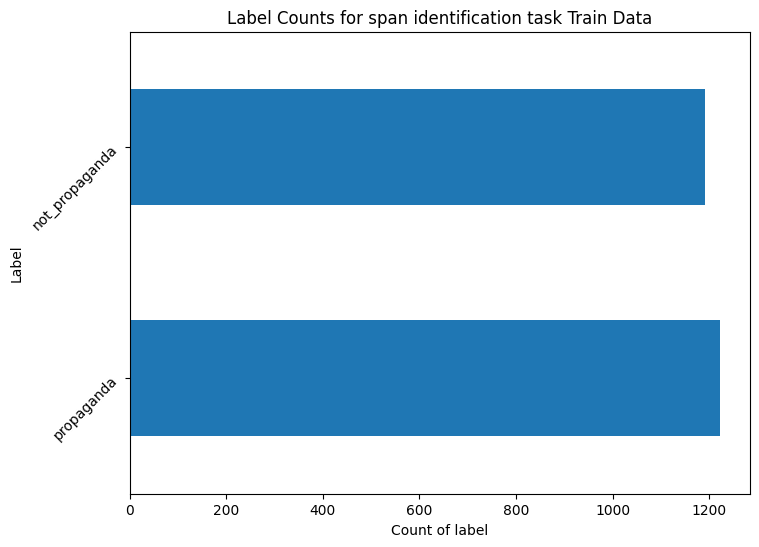

In [58]:
plot_graph(train_df_si,label="Label Counts for span identification task Train Data",x_name="Count of label",y_name="Label") #Plot Label Count for Train Data for Span Identification task

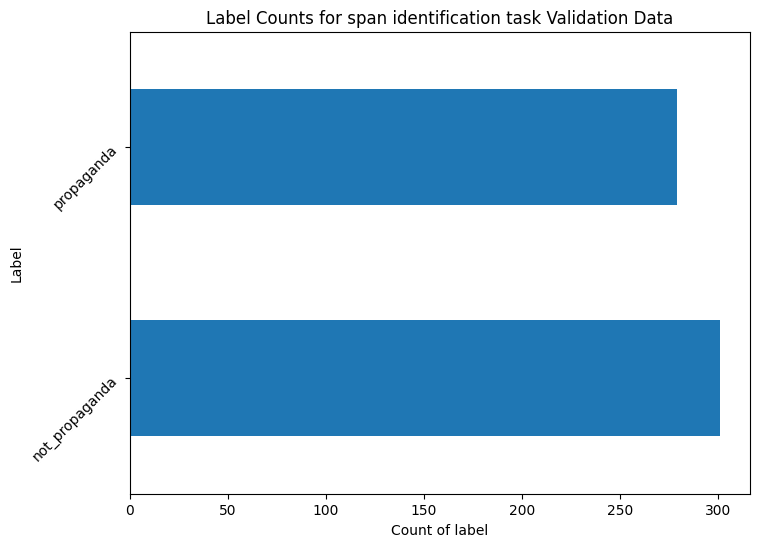

In [59]:
plot_graph(validation_df_si,label="Label Counts for span identification task Validation Data",x_name="Count of label",y_name="Label")  #Plot Label Count for Train Data for Span Identification task

In [60]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased') #Load bert-base-uncased
"""
This function is used to prepare Dataset for BERT, convert the categorical labels with numerical labels 

"""
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self,df,column='text'):
        self.labels=[labels[label] for label in df['label']]  # Replacing all categorical labels with numerical labels 
        self.texts=[tokenizer(text.lower(),padding='max_length',max_length=512,truncation=True,return_tensors="pt") for text in df[column]] #padding to specific length
    
    def classes(self):
        return self.labels          
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self,idx):
        return self.texts[idx]
    
    def __getitem__(self,idx):       #Returns a batch of tokenized texts and corresponding labels.
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)
        
        return batch_texts,batch_y
    

train_data=Dataset(train_df_si)
test_data=Dataset(validation_df_si)

In [ ]:
my_input= train_data.texts[0].input_ids  #extract the firstinput IDs of the first text sample in the train_data

In [ ]:
my_tokens=tokenizer.convert_ids_to_tokens(my_input[0])

In [65]:
use_cuda=torch.cuda.is_available() # PyTorch which checks whether a GPU is available for use. It returns a boolean value of True if a GPU is available, and False if not.
if use_cuda:
  print("GPU acceleration enabled")
else:
  print("GPU acceleration NOT enabled.  If using Colab, have you changed the runtype type and selected GPU as the hardware accelerator?")
device=torch.device("cuda" if use_cuda else "cpu") #This code snippet is a common pattern used in PyTorch to allow for easy switching between CPU and GPU computation, depending on whether a GPU is available or not.

GPU acceleration enabled


In [66]:
train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=2,shuffle=True)
bert=BertModel.from_pretrained('bert-base-uncased').to(device)   # pre-trained bert uncased model moved to device
for train_input,train_label in train_dataloader:                   #Extract input and labels from train dataloader
    input_id,mask,label=prepare_inputs(train_input,train_label,device)  #Prepare inputs
    output=bert(input_ids=input_id,attention_mask=mask,return_dict=False)  #Three seperate output tensors from bert is given as output
    break

print(input_id,mask,label)
print(len(output))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[ 101, 3383, 2010,  ...,    0,    0,    0],
        [ 101, 2077, 8398,  ...,    0,    0,    0]], device='cuda:0') tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]], device='cuda:0') tensor([0, 1], device='cuda:0')
2


tensor([[-0.7130, -0.3569, -0.9152,  ..., -0.7142, -0.5624,  0.5786],
        [-0.3488, -0.4943, -0.9195,  ..., -0.9421, -0.4636, -0.2494]],
       device='cuda:0', grad_fn=<TanhBackward0>)

BERT Base Uncased structure.

```
       [ Input ]
          |
     [ BERT Model ]
          |
   [ Pooled Output ]
          |
    [ Dropout Layer ]
          |
     [ Linear Layer ]
          |
      [ ReLU Layer ]
          |
      [ Output ]

```

In [67]:
"""
This function is used to put the simple classification layer on top of BERT

"""
class BertClassifier(nn.Module):
    
    def __init__(self,dropout=0.5,num_classes=2):
        
        super(BertClassifier,self).__init__()
        
        self.bert=BertModel.from_pretrained('bert-base-uncased') #case does not matter here therefore we use bert base uncased 
        self.dropout=nn.Dropout(dropout)                           #dropout layer with 50% dropout
        self.linear=nn.Linear(768,num_classes)                    #Linear layer  fully connected with 768 input features
        self.relu=nn.ReLU()                                       #Relu Activation for classification of Two classes 
        
    def forward(self,input_id,mask):
        
        last_hidden_layer,pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False) #Take input id and attention_mask and pass to BERT
        dropout_output=self.dropout(pooled_output)  #dropout layer with 50% dropout
        linear_output=self.linear(dropout_output)   #Linear Layer
        final_layer=self.relu(linear_output)         #Pass the output from relu to get the final output
        
        return final_layer 

In [68]:
EPOCHS=3                               #Number of epochs 
model=BertClassifier(num_classes=len(labels.keys()))  #Givinng the model to be used 
LR=1e-6                                  #Learning Rate for model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [69]:
train(model,train_data,test_data,LR,EPOCHS)       #Train the model

100%|██████████| 1207/1207 [04:17<00:00,  4.69it/s]


Epochs: 1 | Train Loss: 0.331 | Train Accuracy: 0.608
Val loss: 0.287 | Val Accuracy: 0.728


100%|██████████| 1207/1207 [04:23<00:00,  4.58it/s]


Epochs: 2 | Train Loss: 0.285 | Train Accuracy: 0.722
Val loss: 0.246 | Val Accuracy: 0.779


100%|██████████| 1207/1207 [04:23<00:00,  4.58it/s]


Epochs: 3 | Train Loss: 0.231 | Train Accuracy: 0.819
Val loss: 0.205 | Val Accuracy: 0.833


In [70]:
output_dir="/content/drive/MyDrive/Sussex/SEM_2/Advance_NLP/Assignment/bert-base-uncased-spanidentificationclassifier"
torch.save(model,output_dir)    #Save model in drive

In [71]:
input_dir="/content/drive/MyDrive/Sussex/SEM_2/Advance_NLP/Assignment/bert-base-uncased-spanidentificationclassifier"
complete_model=torch.load(input_dir) #Load model from drive

In [72]:
predictions=evaluate(model, test_data)  #predict using evaluate function

 18%|█▊        | 51/290 [00:03<00:16, 14.11it/s]

Accuracy so far =  0.900


 35%|███▍      | 101/290 [00:07<00:13, 13.69it/s]

Accuracy so far =  0.850


 52%|█████▏    | 151/290 [00:10<00:11, 11.92it/s]

Accuracy so far =  0.850


 69%|██████▉   | 201/290 [00:14<00:06, 13.30it/s]

Accuracy so far =  0.838


 87%|████████▋ | 251/290 [00:18<00:02, 13.23it/s]

Accuracy so far =  0.840


100%|██████████| 290/290 [00:21<00:00, 13.44it/s]

Test accuracy:  0.833


In [73]:
flattened=[]
for batch in predictions:        # Iterating from the predictions.
  for pred in batch:
    flattened.append(reverse_index[pred.item()]) # Convert back predicted label and add to flattended list
validation_df_si["prediction"]=flattened      # Assigning list in prediction column
validation_df_si.head(50)


,text,label,prediction
0,"On average, between 300 and 600 infections are...",not_propaganda,not_propaganda
1,Mostly because <BOS> the country would not las...,propaganda,propaganda
2,Lyndon Johnson <BOS> gets Earl Warren and Sen....,propaganda,propaganda
3,<BOS> You <EOS> may opt out at anytime.,not_propaganda,not_propaganda
4,It must be exacted from him directly in order ...,propaganda,propaganda
5,Is it any wonder that priests and laity alike ...,propaganda,propaganda
6,Health workers have been asked to work with co...,propaganda,not_propaganda
7,The Best of <BOS> Jacob <EOS> G. Hornberger,not_propaganda,not_propaganda
8,Trump began his remarks by setting out <BOS> I...,propaganda,propaganda
9,"<BOS> Now, the pope’s reply to my testimony wa...",propaganda,propaganda


In [74]:
all_labels=validation_df_si['label']      
all_predictions=validation_df_si['prediction']

In [75]:
"""
model_metrics function is used to give precision, recall and f1 score for each label in data
"""

def model_metrics(labels=labels,all_labels=all_labels,all_predictions=all_predictions,model_name="BERT",task_name="Span Identification"):
  tp={}
  fp={}
  fn={}
  tn={}

  for label1,pred1 in zip(all_labels,all_predictions):
      for label in labels.keys():
          if label1==label:
              if pred1==label:
                  tp[label]=tp.get(label,0)+1
              else:
                  fn[label]=fn.get(label,0)+1
              
          else:
              if pred1==label:
                  fp[label]=fp.get(label,0)+1
              else:
                  tn[label]=tn.get(label,0)+1
                


  precision={label:value/(value+fp.get(label,0)) for label,value in tp.items()}
  recall={label:value/(value+fn.get(label,0)) for label,value in tp.items()}
  f1={label:(2*value*recall.get(label,0))/(value+recall.get(label,0)) for label,value in precision.items()}

  print(f"Precision {task_name} for {model_name} model",precision)
  print(f"Recall {task_name} for {model_name}  model",recall)
  print(f"F1 {task_name} for {model_name}  model",f1)


In [76]:
model_metrics(labels=labels,all_labels=all_labels,all_predictions=all_predictions,model_name="BERT",task_name="Span Identification")  #Call model_metrics to analyze model performance

Precision Span Identification for BERT model {'not_propaganda': 0.8445945945945946, 'propaganda': 0.8204225352112676}
Recall Span Identification for BERT  model {'not_propaganda': 0.8305647840531561, 'propaganda': 0.8351254480286738}
F1 Span Identification for BERT  model {'not_propaganda': 0.8375209380234506, 'propaganda': 0.8277087033747781}


**Error Analysis in Span Identification Task for BERT Model**

Precision is better for not_propaganda and recall is better for propoganda. This suggests that classifier is overpredicting propoganda. This is consistent with there being more training data for propoganda.

In [77]:
train_df_si_copy = train_df_si.copy(deep=True)
train_df_si_copy['len_of_span'] = train_df_si_copy['text'].apply(len)
train_df_si_copy.head()

,text,label,len_of_span
0,"No, <BOS> he <EOS> will not be confirmed.",not_propaganda,42
1,This declassification effort <BOS> won’t make ...,not_propaganda,104
2,The Obama administration misled the <BOS> Amer...,propaganda,140
3,“It looks like we’re capturing the demise of t...,not_propaganda,213
4,"<BOS> Location: Westerville, Ohio <EOS>",not_propaganda,40


Below graph shows the mean length of characters for labels in training data.

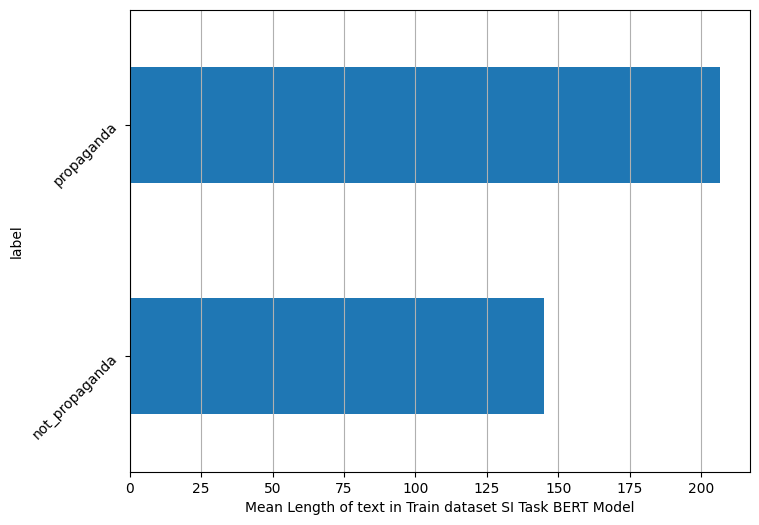

Length for labels are as follows {'not_propaganda': 145.17, 'propaganda': 206.75}


In [78]:
mean_length_of_char_in_df(train_df_si_copy,groupby_col="label",col="len_of_span",xlabel_name="Mean Length of text in Train dataset SI Task BERT Model")

In [79]:
validation_df_si_copy = validation_df_si.copy(deep=True)
validation_df_si_copy['len_of_span'] = validation_df_si_copy['text'].apply(len)
validation_df_si_copy.head()

,text,label,prediction,len_of_span
0,"On average, between 300 and 600 infections are...",not_propaganda,not_propaganda,157
1,Mostly because <BOS> the country would not las...,propaganda,propaganda,112
2,Lyndon Johnson <BOS> gets Earl Warren and Sen....,propaganda,propaganda,166
3,<BOS> You <EOS> may opt out at anytime.,not_propaganda,not_propaganda,40
4,It must be exacted from him directly in order ...,propaganda,propaganda,169


Below graph shows the mean length of characters for labels in Validation data.

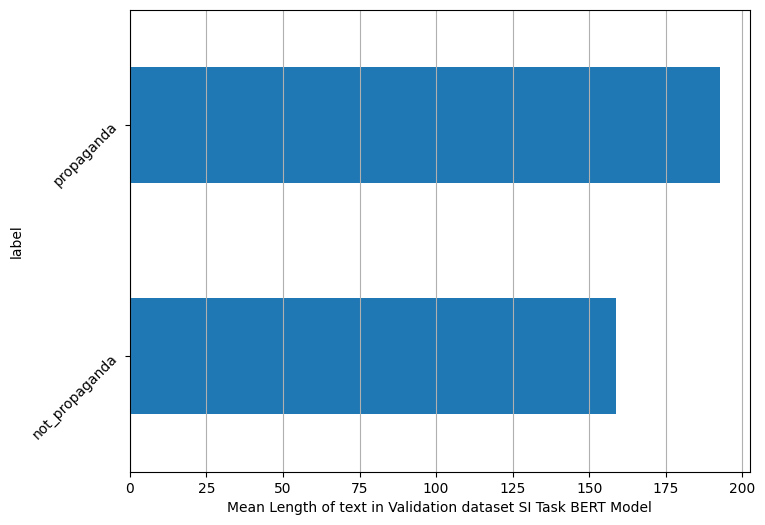

Length for labels are as follows {'not_propaganda': 158.81, 'propaganda': 192.77}


In [80]:
mean_length_of_char_in_df(validation_df_si_copy,groupby_col="label",col="len_of_span",xlabel_name="Mean Length of text in Validation dataset SI Task BERT Model")

In [82]:
validation_df_si.head()

,text,label,prediction
0,"On average, between 300 and 600 infections are...",not_propaganda,not_propaganda
1,Mostly because <BOS> the country would not las...,propaganda,propaganda
2,Lyndon Johnson <BOS> gets Earl Warren and Sen....,propaganda,propaganda
3,<BOS> You <EOS> may opt out at anytime.,not_propaganda,not_propaganda
4,It must be exacted from him directly in order ...,propaganda,propaganda


In [86]:
mean_lengths_wrong_pred =calculate_mean_sentence_lengths(validation_df_si)  #Printing Wrong Predicted sentence mean length
print("Wrong Prediction Sentence Average length:\n",mean_lengths_wrong_pred)

Wrong Prediction Sentence Average length:
 prediction
not_propaganda    152.956522
propaganda        323.627451
Name: text, dtype: float64


The sentences where BERT has predicted wrong class is because as we can see when we trained the model average length of propaganda was around 206 and for not_propoganda it was 145. 

But in Validation data set the average length of propaganda'was around 192 and for not_propoganda it was 158. 

When we perform error analysis of sentences which are** wrongly predicted** as **propoganda** but the **gold label** is **not propoganda**, the avarage length of sentence is around **323** which is close to the average length of **propoganda label** in **train** which is 206, hence model is getting confused and classifying these sentences as **propoganda**.

If we analyse for sentences which are **wrongly predicted** as **not_propaganda** but the **gold label** is **propoganda**, the avarage length of sentence is around **152** which is very close to the average length of **not_propoganda label** in **train** which is 145, hence model is getting confused and classifying these sentences as **not_propoganda**.

## **LSTM For Span Identification Task**

"Below code for LSTM is adapted from github repository of shabbirg89/
Youtube-2021 and modified according to the task."

(Source: https://github.com/shabbirg89/Youtube-2021/blob/main/Multiclass_Text_Classifier_LSTM.ipynb)

LSTM: An artificial neural network called Long Short-Term Memory (LSTM) is employed in deep learning and artificial intelligence. LSTM features feedback connections as opposed to typical feedforward neural networks. Such a recurrent neural network (RNN) can analyse whole data sequences, such as audio or video, in addition to single data points, like images. Because of this feature, LSTM networks are perfect for handling and forecasting data.

In [105]:
train_df_si,validation_df_si,labels,reverse_index = span_identification_df() # Calling the span_identification_df to get the data filtered according to span identification task

Training Dataframe for Span Identification
                                                text           label
0         No, <BOS> he <EOS> will not be confirmed.   not_propaganda
1  This declassification effort <BOS> won’t make ...  not_propaganda
2  The Obama administration misled the <BOS> Amer...      propaganda
3  “It looks like we’re capturing the demise of t...  not_propaganda
4           <BOS> Location: Westerville, Ohio <EOS>   not_propaganda
----------------------------------------------------------------------------------------------------------------
Validation Dataframe for Span Identification
                                                text           label
0  On average, between 300 and 600 infections are...  not_propaganda
1  Mostly because <BOS> the country would not las...      propaganda
2  Lyndon Johnson <BOS> gets Earl Warren and Sen....      propaganda
3           <BOS> You <EOS> may opt out at anytime.   not_propaganda
4  It must be exacted from him directly 

In [106]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\|@]')   
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+]')

In [107]:
def clean_text(text):
    """
    Thisi function is used to convert the text to lower case and replace above defined Bad Symbols
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    return text

train_df_si['text'] = train_df_si['text'].apply(clean_text) 

In [108]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000 # Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256 # This is fixed length
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='#$%&()*+/<=>@[\]^{|}~', lower=True)   #Initialize tokenizer and give filters
tokenizer.fit_on_texts(train_df_si['text'].values)   #Tokenize the data in train_df_si
word_index = tokenizer.word_index              
print('Found %s unique tokens.' % len(word_index))

Found 9219 unique tokens.


In [109]:
X_train = tokenizer.texts_to_sequences(train_df_si['text'].values)   #Load the tokenized data to X_train
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (2414, 256)


In [110]:
Y_train = pd.get_dummies(train_df_si['label']).values #creates a new DataFrame with one-hot encoded labels, extract the numpy values 
print('Shape of label tensor:', Y_train.shape)

Shape of label tensor: (2414, 2)


LSTM structure


```
       [ Input ]
          |
    [Embedding layer]
          |
   [ SpatialDropout1D layer ]
          |
      [LSTM layer ]
          |
[ Dense layer Sigmoid Activation ]
          |
      [ Output ]     

```

In [111]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))  #Embdedding layer takes the input text data and converts it into a dense vector 
model.add(SpatialDropout1D(0.2))                           #dropout regularization to the embedding layer by randomly dropping out entire 1D feature maps.
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))  #LSTM with 100 units and 20% droput probability
model.add(Dense(2, activation='sigmoid'))                  #2 output Units in a  Sigmoid Activation function 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # Adam optimizer and binary_crossentropy loss function 
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 256, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________
None


In [112]:
epochs = 5   #Number of epochs
batch_size = 4  #Batch Size 

#Traon the model
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
543/543 [==============================] - 396s 722ms/step - loss: 0.5904 - accuracy: 0.6943 - val_loss: 0.5133 - val_accuracy: 0.7479
Epoch 2/5
543/543 [==============================] - 446s 822ms/step - loss: 0.3447 - accuracy: 0.8564 - val_loss: 0.5093 - val_accuracy: 0.7562
Epoch 3/5
543/543 [==============================] - 382s 703ms/step - loss: 0.1169 - accuracy: 0.9609 - val_loss: 0.6519 - val_accuracy: 0.7273
Epoch 4/5
543/543 [==============================] - 375s 690ms/step - loss: 0.0368 - accuracy: 0.9890 - val_loss: 0.9654 - val_accuracy: 0.6570
Epoch 5/5
543/543 [==============================] - 346s 635ms/step - loss: 0.0226 - accuracy: 0.9936 - val_loss: 0.9223 - val_accuracy: 0.7149


In [113]:
validation_df_si['text'] = validation_df_si['text'].apply(clean_text)  #Clean the validation data

In [114]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='#$%&()*+/<=>@[\]^{|}~', lower=True)  #Initialize tokenizer and give filters
tokenizer.fit_on_texts(validation_df_si['text'].values)  #Tokenize the data in validation_df_si
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4224 unique tokens.


In [115]:
X_test = tokenizer.texts_to_sequences(validation_df_si['text'].values)  #Load the tokenized data to X_test
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (580, 256)


In [116]:
Y_test = pd.get_dummies(validation_df_si['label']).values #creates a new DataFrame with one-hot encoded labels, extract the numpy values 
print('Shape of label tensor:', Y_test.shape)

Shape of label tensor: (580, 2)


In [117]:
accr = model.evaluate(X_test,Y_test)  #evaluate model and give accuracy 
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

19/19 [==============================] - 1s 72ms/step - loss: 1.5093 - accuracy: 0.6103
Test set
  Loss: 1.509
  Accuracy: 0.610


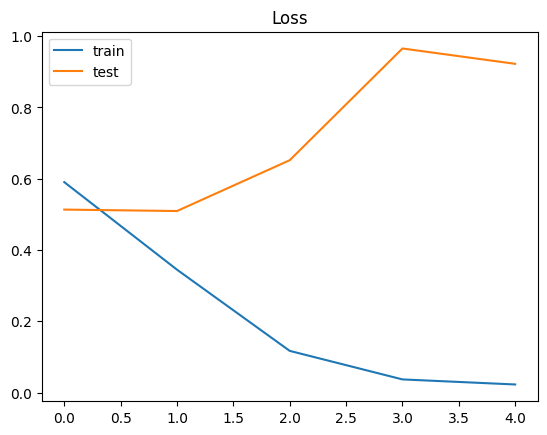

In [118]:
plt.title('Loss')                                     # Plot train and test loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

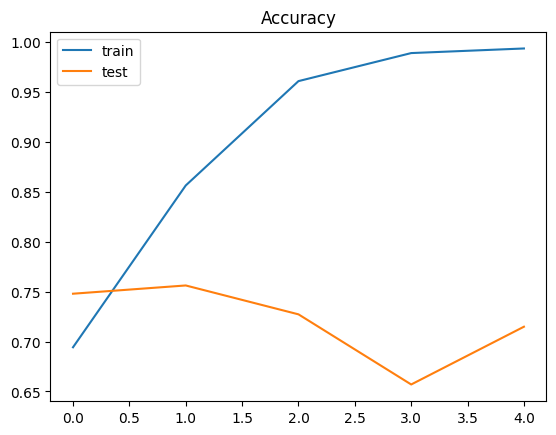

In [119]:
plt.title('Accuracy')                      # Plot train and test accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# **Propaganda Technique Classification Task**

In technique classification task we have to detect the type of propoganda technique usedin the given text from article. Hence we will use the technique_classification_df function to filter the train and validation data and give us back only those rows which contains propoganda technique used in the text.

## **BERT Base Cased Model For Technique Classification Task**

"Below functions evaluate, prepare_inputs and train and code for this section are taken from code available in the 6th Advance NLP Lab Sussex University."

(Source: https://canvas.sussex.ac.uk/courses/22822/pages/week-slash-topic-6-transfer-learning-with-large-pretrained-models?wrap=1)

In [87]:
train_df_tc,validation_df_tc,labels,reverse_index = technique_classification_df()  # Calling the technique_classification_df to get the data filtered according to technique classification task

Training Dataframe for Technique Classification
                                                 text  \
2   The Obama administration misled the <BOS> Amer...   
5   Hitler <BOS> annihilated <EOS> 400,000 Germans...   
8   As noted above, at this point literally every ...   
10  His account was suspended for violating Twitte...   
12  A couple of seemingly unrelated events this pa...   

                       label  
2                flag_waving  
5            loaded_language  
8                      doubt  
10     name_calling,labeling  
12  appeal_to_fear_prejudice  
----------------------------------------------------------------------------------------------------------------
Validation Dataframe for Technique Classification
                                                text  \
1  Mostly because <BOS> the country would not las...   
2  Lyndon Johnson <BOS> gets Earl Warren and Sen....   
4  It must be exacted from him directly in order ...   
5  Is it any wonder that priests and

We will use bert-base-cased in the technique classsification task as to detect different propoganda techniques case of text matters.

"Below code and functions used in technique classification for BERT evaluate, prepare_inputs and train are taken from code available in the 6th Advance NLP Lab Sussex University and modidfied according to the given task."

(Source: https://canvas.sussex.ac.uk/courses/22822/pages/week-slash-topic-6-transfer-learning-with-large-pretrained-models?wrap=1)

In [88]:
"""
This function is used to prepare Dataset for BERT, convert the categorical labels with numerical labels 

"""
tokenizer=BertTokenizer.from_pretrained('bert-base-cased') # Load bert-base-cased

class Dataset(torch.utils.data.Dataset):
    
    def __init__(self,df,column='text'):
        self.labels=[labels[label] for label in df['label']]
        self.texts=[tokenizer(text,padding='max_length',max_length=256,truncation=True,return_tensors="pt") for text in df[column]] #padding to specific length
    
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self,idx):
        return self.texts[idx]
    
    def __getitem__(self,idx):                         #Returns a batch of tokenized texts and corresponding labels.
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)
        
        return batch_texts,batch_y
    

train_data=Dataset(train_df_tc)
test_data=Dataset(validation_df_tc)

In [91]:
my_input= train_data.texts[0].input_ids #extract the firstinput IDs of the first text sample in the train_data

In [ ]:
my_tokens=tokenizer.convert_ids_to_tokens(my_input[0])

In [94]:
use_cuda=torch.cuda.is_available() # PyTorch which checks whether a GPU is available for use. It returns a boolean value of True if a GPU is available, and False if not.
if use_cuda:
  print("GPU acceleration enabled")
else:
  print("GPU acceleration NOT enabled.  If using Colab, have you changed the runtype type and selected GPU as the hardware accelerator?")
device=torch.device("cuda" if use_cuda else "cpu") #This code snippet is a common pattern used in PyTorch to allow for easy switching between CPU and GPU computation, depending on whether a GPU is available or not.

GPU acceleration enabled


In [95]:
train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=2,shuffle=True)
bert=BertModel.from_pretrained('bert-base-cased').to(device)        # pre-trained bert cased model moved to device
for train_input,train_label in train_dataloader:                   #Extract input and labels from train dataloader  
    input_id,mask,label=prepare_inputs(train_input,train_label,device)  #Prepare inputs
    output=bert(input_ids=input_id,attention_mask=mask,return_dict=False)  #Three seperate output tensors from bert is given as output
    break

print(input_id,mask,label)
print(len(output))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[  101,   789,  1247,  1110,   133,   139,  9025,   135,  2839,   170,
          6756,  3029,  2640,   133,   142,  9025,   135,  1115,   164,  3279,
         23670,  7308,   166, 11942,   150,  1665,  1658, 26823,  1105,  7803,
         22210,  1926,  1209,  2621,  1142,  1645,  1106,  1243,  1763,  1103,
         25492,   118, 13520,   790, 10974,  4912,  1170, 11905,  2295,   117,
          1163,  1103,  1884,   118,  3249,  1104,  9314, 14697, 13329,  1830,
         13791,  1150,  1144,  1691,  1196,  1103,  3732,  2031,  1242,  1551,
           119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

tensor([[-0.6804,  0.3530,  0.9992,  ...,  0.9998, -0.7557,  0.9596],
        [-0.6011,  0.3628,  0.9996,  ...,  0.9999, -0.8586,  0.9866]],
       device='cuda:0', grad_fn=<TanhBackward0>)

BERT Base cased strcuture

```
       [ Input ]
          |
     [ BERT Model ]
          |
   [ Pooled Output ]
          |
    [ Dropout Layer ]
          |
    [ Linear Layer ]
          |
    [ ReLU Layer ]
          |
    [ SoftMax Layer ]
          |
      [ Output ]

```

In [96]:
"""
This function is used to put the simple classification layer on top of BERT

"""
class BertClassifier(nn.Module):
    
    def __init__(self,dropout=0.5,num_classes=8):
        
        super(BertClassifier,self).__init__()
        
        self.bert=BertModel.from_pretrained('bert-base-cased') # Using Bert model cased version because for this task case of text matters
        self.dropout=nn.Dropout(dropout)                       #dropout layer with 50% dropout
        self.linear=nn.Linear(768,num_classes)                   #Linear layer  fully connected with 768 input features
        self.relu=nn.ReLU()                                      #Relu Activation Function
        self.softmax = nn.Softmax(dim=1)                    #Softmax with 8 classes
        
    def forward(self,input_id,mask):
        
        last_hidden_layer,pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        dropout_output=self.dropout(pooled_output)  #dropout layer with 50% dropout
        linear_output=self.linear(dropout_output) #Linear Layer
        relu_output = self.relu(linear_output)  #Pass the output to relu
        final_layer = self.softmax(relu_output)  #Pass the output from relu to Softmax to get the final output
        
        return final_layer

In [97]:
EPOCHS=10                                               #Number of epochs 
model=BertClassifier(num_classes=len(labels.keys()))   #Givinng the model to be used 
LR=1e-5                                                  #Learning Rate for model

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [98]:
train(model,train_data,test_data,LR,EPOCHS)             #Train the model

100%|██████████| 612/612 [01:14<00:00,  8.23it/s]


Epochs: 1 | Train Loss: 1.038 | Train Accuracy: 0.150
Val loss: 1.033 | Val Accuracy: 0.219


100%|██████████| 612/612 [01:15<00:00,  8.13it/s]


Epochs: 2 | Train Loss: 1.025 | Train Accuracy: 0.194
Val loss: 1.022 | Val Accuracy: 0.229


100%|██████████| 612/612 [01:15<00:00,  8.16it/s]


Epochs: 3 | Train Loss: 1.014 | Train Accuracy: 0.234
Val loss: 1.016 | Val Accuracy: 0.226


100%|██████████| 612/612 [01:14<00:00,  8.23it/s]


Epochs: 4 | Train Loss: 0.991 | Train Accuracy: 0.262
Val loss: 1.003 | Val Accuracy: 0.258


100%|██████████| 612/612 [01:14<00:00,  8.22it/s]


Epochs: 5 | Train Loss: 0.965 | Train Accuracy: 0.362
Val loss: 0.972 | Val Accuracy: 0.358


100%|██████████| 612/612 [01:14<00:00,  8.23it/s]


Epochs: 6 | Train Loss: 0.914 | Train Accuracy: 0.478
Val loss: 0.921 | Val Accuracy: 0.459


100%|██████████| 612/612 [01:14<00:00,  8.22it/s]


Epochs: 7 | Train Loss: 0.848 | Train Accuracy: 0.617
Val loss: 0.898 | Val Accuracy: 0.487


100%|██████████| 612/612 [01:14<00:00,  8.22it/s]


Epochs: 8 | Train Loss: 0.789 | Train Accuracy: 0.725
Val loss: 0.888 | Val Accuracy: 0.495


100%|██████████| 612/612 [01:14<00:00,  8.22it/s]


Epochs: 9 | Train Loss: 0.761 | Train Accuracy: 0.766
Val loss: 0.899 | Val Accuracy: 0.459


100%|██████████| 612/612 [01:14<00:00,  8.22it/s]


Epochs: 10 | Train Loss: 0.736 | Train Accuracy: 0.813
Val loss: 0.866 | Val Accuracy: 0.538


In [99]:
output_dir="/content/drive/MyDrive/Sussex/SEM_2/Advance_NLP/Assignment/bert-base-cased-propogandatechniqueclassifier"
torch.save(model,output_dir) #Save model in drive

In [100]:
input_dir="/content/drive/MyDrive/Sussex/SEM_2/Advance_NLP/Assignment/bert-base-cased-propogandatechniqueclassifier"
complete_model=torch.load(input_dir)#Load model from drive

In [101]:
predictions=evaluate(model, test_data)  #predict using evaluate function

 38%|███▊      | 53/140 [00:02<00:04, 18.22it/s]

Accuracy so far =  0.530


 74%|███████▍  | 104/140 [00:04<00:01, 27.78it/s]

Accuracy so far =  0.510


100%|██████████| 140/140 [00:06<00:00, 22.62it/s]

Test accuracy:  0.538


In [102]:
flattened=[]
for batch in predictions:                     # Iterating from the predictions
  for pred in batch:
    flattened.append(reverse_index[pred.item()])   # Convert back predicted label and add to flattended list
validation_df_tc["prediction"]=flattened     # Assigning list in prediction column
validation_df_tc.head(50)

,text,label,prediction
1,Mostly because <BOS> the country would not las...,causal_oversimplification,flag_waving
2,Lyndon Johnson <BOS> gets Earl Warren and Sen....,appeal_to_fear_prejudice,causal_oversimplification
4,It must be exacted from him directly in order ...,repetition,"name_calling,labeling"
5,Is it any wonder that priests and laity alike ...,"name_calling,labeling","name_calling,labeling"
6,Health workers have been asked to work with co...,loaded_language,flag_waving
8,Trump began his remarks by setting out <BOS> I...,flag_waving,flag_waving
9,"<BOS> Now, the pope’s reply to my testimony wa...",doubt,causal_oversimplification
16,"For Trump, that amounted to a <BOS> triumphant...",loaded_language,loaded_language
18,“It’s time for <BOS> our <EOS> leaders in Wash...,flag_waving,flag_waving
19,<BOS> This will not only serve to bolster the ...,appeal_to_fear_prejudice,appeal_to_fear_prejudice


In [103]:
all_labels=validation_df_tc['label']
all_predictions=validation_df_tc['prediction']

In [104]:
model_metrics(labels=labels,all_labels=all_labels,all_predictions=all_predictions,model_name="BERT",task_name="Task Classification") #Call model_metrics to analyze model performance

Precision Task Classification for BERT model {'name_calling,labeling': 0.6666666666666666, 'flag_waving': 0.5555555555555556, 'loaded_language': 0.4523809523809524, 'appeal_to_fear_prejudice': 0.6222222222222222, 'causal_oversimplification': 0.5142857142857142, 'doubt': 0.6666666666666666, 'exaggeration,minimisation': 0.29411764705882354}
Recall Task Classification for BERT  model {'name_calling,labeling': 0.5161290322580645, 'flag_waving': 0.8974358974358975, 'loaded_language': 0.5135135135135135, 'appeal_to_fear_prejudice': 0.6511627906976745, 'causal_oversimplification': 0.5806451612903226, 'doubt': 0.631578947368421, 'exaggeration,minimisation': 0.35714285714285715}
F1 Task Classification for BERT  model {'name_calling,labeling': 0.5818181818181819, 'flag_waving': 0.6862745098039216, 'loaded_language': 0.48101265822784806, 'appeal_to_fear_prejudice': 0.6363636363636364, 'causal_oversimplification': 0.5454545454545455, 'doubt': 0.6486486486486486, 'exaggeration,minimisation': 0.3225

## **GLOVE AND Bidrectional LSTM For Technique Classification Task**

GLOVE:  Global vectors for word representation is referred to as GloVe. It is a Stanford-developed unsupervised learning technique that creates word embeddings by combining the global word-word co-occurrence matrix from a corpus. Interesting linear substructures of the word are displayed in vector space by the resulting embeddings.

Bi-LSTM: Bi-directional Long Short Term Memory (Bi-LSTM):
Recurrent neural networks that are bidirectional are basically just two separate RNNs combined. The networks may access both forward and backward information about the sequence thanks to this structure at each time step.

When using bidirectional, your inputs will be processed in two different directions: one from the present to the future and the other from the future to the present. This method differs from unidirectional in that information from the future is preserved in the LSTM that runs backward, and by combining the two hidden states, you can preserve data from both the present and the future at any given time.

"Below code for this section are taken from code available in the Classification using Long Short Term Memory & GloVe (Global Vectors for Word Representation) article of Medium."

(Source: https://medium.com/analytics-vidhya/classification-using-long-short-term-memory-glove-global-vectors-for-word-representation-254d02d5e158)

In [153]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [154]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [155]:
!pip install keras tensorflow
!apt install python3-keras python3-tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package python3-tensorflow


In [156]:
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn import preprocessing
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import tensorflow as tf
print(tf.__version__)

2.12.0


In [157]:
train_df_tc,validation_df_tc,labels,reverse_index = technique_classification_df()  # Calling the technique_classification_df to get the data filtered according to technique classification task

Training Dataframe for Technique Classification
                                                 text  \
2   The Obama administration misled the <BOS> Amer...   
5   Hitler <BOS> annihilated <EOS> 400,000 Germans...   
8   As noted above, at this point literally every ...   
10  His account was suspended for violating Twitte...   
12  A couple of seemingly unrelated events this pa...   

                       label  
2                flag_waving  
5            loaded_language  
8                      doubt  
10     name_calling,labeling  
12  appeal_to_fear_prejudice  
----------------------------------------------------------------------------------------------------------------
Validation Dataframe for Technique Classification
                                                text  \
1  Mostly because <BOS> the country would not las...   
2  Lyndon Johnson <BOS> gets Earl Warren and Sen....   
4  It must be exacted from him directly in order ...   
5  Is it any wonder that priests and

In [158]:
train_df_tc["text"]=train_df_tc["text"].str.lower()   #Converting the data to lower case

In [159]:
"""
This function helps in Lemmatizing the data and converting to its base form to reduce dimensionality of data and normalizing data
"""

def getLemmText(text):
 tokens=word_tokenize(text)
 lemmatizer = WordNetLemmatizer()
 tokens=[lemmatizer.lemmatize(word) for word in tokens]
 return " ".join(tokens)
 
train_df_tc["text"] = list(map(getLemmText,train_df_tc["text"]))

In [160]:
"""
This function helps in removing prefix and sufix from the data, performing Stemming to reduce dimensionality of data and normalizing data
"""

def getStemmText(text):
 tokens=word_tokenize(text)
 ps = PorterStemmer()    
 tokens=[ps.stem(word) for word in tokens]
 return " ".join(tokens)
train_df_tc['text'] = list(map(getStemmText,train_df_tc['text']))

In [161]:
label_encoder = preprocessing.LabelEncoder()                   #Loading the label Encoder
labels = label_encoder.fit_transform(train_df_tc.label.values)  #Fit and transform the data
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [162]:
#Splitting the train data for training and testing
xtrain, xtest, ytrain, ytest = train_test_split(train_df_tc.text.values, labels,   
 stratify=labels, 
 random_state=42, 
 test_size=0.1, shuffle=True) 

In [164]:
embeddings_index = {}
f = open('/content/drive/MyDrive/Sussex/SEM_2/Advance_NLP/Assignment/glove.6B/glove.6B.100d.txt',encoding='utf8') #Loading Glove with 100 dimension

for line in tqdm(f):
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:17, 23439.20it/s]

Found 400000 word vectors.


In [165]:
VOCABULARY_SIZE = 2000  # It defines the maximum number of words in tokenizer.
MAX_LENGTH = 60  #It defines the maximum length of each sentence, including padding.

In [166]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)            #Initialize the tokenizer with number of words in vocabulary
tokenizer.fit_on_texts(list(xtrain) + list(xtest))

In [167]:
xtrain_sequence = tokenizer.texts_to_sequences(xtrain)            #Tokenize xtrain data
xtest_sequence = tokenizer.texts_to_sequences(xtest)              #Tokenize xtest data

In [168]:
xtrain_padding = pad_sequences(xtrain_sequence, maxlen=MAX_LENGTH)     #Add Padding in xtrain data
xtest_padding = pad_sequences(xtest_sequence, maxlen=MAX_LENGTH)       #Add Padding in xtest data
word_index = tokenizer.word_index

In [169]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):                  #Creating embedding matrix for model
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

100%|██████████| 4845/4845 [00:00<00:00, 306756.68it/s]


GLOVE AND Bidrectional LSTM strcuture

```
       [ Input ]
          |
    [Embedding layer]
          |
   [ SpatialDropout1D layer ]
          |
  [Bidirectional LSTM layer ]
          |
  [ Dense layer Relu Activation]
          |
  [ Dense layer Softmax Activation]
          |
      [ Output ]     

```

In [170]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
 100,
 weights=[embedding_matrix],
 input_length=MAX_LENGTH,
 trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.3)))
model.add(Dense(1024, activation="relu"))
model.add(Dense(8, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [172]:
ytrain_encode = np_utils.to_categorical(ytrain)        #Convert data to numerical form in ytrain
ytest_encode = np_utils.to_categorical(ytest)            #Convert data to numerical form in ytest

In [173]:
history = model.fit(xtrain_padding, y=ytrain_encode, batch_size=8, epochs=20, verbose=1, validation_data=(xtest_padding, ytest_encode)) #Train the model

Epoch 1/20
138/138 [==============================] - 118s 806ms/step - loss: 2.0491 - accuracy: 0.1864 - val_loss: 1.9459 - val_accuracy: 0.1707
Epoch 2/20
138/138 [==============================] - 121s 881ms/step - loss: 1.9843 - accuracy: 0.1900 - val_loss: 1.8703 - val_accuracy: 0.1870
Epoch 3/20
138/138 [==============================] - 80s 583ms/step - loss: 1.9201 - accuracy: 0.2145 - val_loss: 1.8126 - val_accuracy: 0.2358
Epoch 4/20
138/138 [==============================] - 73s 532ms/step - loss: 1.8708 - accuracy: 0.2482 - val_loss: 1.8171 - val_accuracy: 0.1951
Epoch 5/20
138/138 [==============================] - 87s 632ms/step - loss: 1.8415 - accuracy: 0.2436 - val_loss: 1.7793 - val_accuracy: 0.2764
Epoch 6/20
138/138 [==============================] - 85s 611ms/step - loss: 1.7753 - accuracy: 0.2727 - val_loss: 1.8221 - val_accuracy: 0.2033
Epoch 7/20
138/138 [==============================] - 132s 956ms/step - loss: 1.7775 - accuracy: 0.3045 - val_loss: 1.8122 - val

## **Experiment with Custom Pytorch Implementation of Roberta For Technique Classification Task**

"Below functions evaluate, prepare_inputs and train and code for this section are taken from code available in the 6th Advance NLP Lab Sussex University."

(Source: https://canvas.sussex.ac.uk/courses/22822/pages/week-slash-topic-6-transfer-learning-with-large-pretrained-models?wrap=1)

In [175]:
train_df_tc,validation_df_tc,labels,reverse_index = technique_classification_df()

Training Dataframe for Technique Classification
                                                 text  \
2   The Obama administration misled the <BOS> Amer...   
5   Hitler <BOS> annihilated <EOS> 400,000 Germans...   
8   As noted above, at this point literally every ...   
10  His account was suspended for violating Twitte...   
12  A couple of seemingly unrelated events this pa...   

                       label  
2                flag_waving  
5            loaded_language  
8                      doubt  
10     name_calling,labeling  
12  appeal_to_fear_prejudice  
----------------------------------------------------------------------------------------------------------------
Validation Dataframe for Technique Classification
                                                text  \
1  Mostly because <BOS> the country would not las...   
2  Lyndon Johnson <BOS> gets Earl Warren and Sen....   
4  It must be exacted from him directly in order ...   
5  Is it any wonder that priests and

In [178]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')  #Using Roberta Model but same architecture as BERT

class Dataset(torch.utils.data.Dataset):
    
    def __init__(self,df,column='text'):
        self.labels=[labels[label] for label in df['label']]
        self.texts=[tokenizer(text,padding='max_length',max_length=256,truncation=True,return_tensors="pt") for text in df[column]] #padding to specific length
        #Return_tensors = “pt” is just for the tokenizer to return PyTorch tensors. If you don't want this to happen(maybe you want it to return a list), then you can remove the parameter and it will return lists.
    
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self,idx):
        return self.texts[idx]
    
    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)
        
        return batch_texts,batch_y
    

train_data=Dataset(train_df_tc)
test_data=Dataset(validation_df_tc)

In [179]:
my_input= train_data.texts[0].input_ids

In [180]:
my_tokens=tokenizer.convert_ids_to_tokens(my_input[0])

In [181]:
use_cuda=torch.cuda.is_available() # PyTorch which checks whether a GPU is available for use. It returns a boolean value of True if a GPU is available, and False if not.
if use_cuda:
  print("GPU acceleration enabled")
else:
  print("GPU acceleration NOT enabled.  If using Colab, have you changed the runtype type and selected GPU as the hardware accelerator?")
device=torch.device("cuda" if use_cuda else "cpu") #This code snippet is a common pattern used in PyTorch to allow for easy switching between CPU and GPU computation, depending on whether a GPU is available or not.

GPU acceleration enabled


In [182]:
train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=2,shuffle=True)
bert=RobertaModel.from_pretrained('roberta-base').to(device)
for train_input,train_label in train_dataloader:
    input_id,mask,label=prepare_inputs(train_input,train_label,device)
    output=bert(input_ids=input_id,attention_mask=mask,return_dict=False)
    # device = torch.device("cuda")
    # model.cuda()
    break

print(input_id,mask,label)
print(len(output))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[    0, 41552,   387,  3196, 15698, 16167, 30365,   150,     5,   897,
          1571,     8,    10,   367,   205, 15843,    32,   314,     7,  1235,
             7,  4538,     6,    25,   275,    51,    64,     6,     5,  5891,
          5307,     9,     5,  2197,   136,     5, 13052,     9,    10, 43959,
            15,     5,  8381,     9,  2155, 13546,     5, 45007,    29,    19,
            10,  5184,     9,  9208,     8,    10,  6587,  9563,   137,     5,
          1801,  3052, 28696,   717,  3196, 48691,  1437,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [183]:
class RobertaClassifier(nn.Module):
    
    def __init__(self, dropout=0.5, num_classes=8):
        
        super(RobertaClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_ids, attention_mask):
        
        last_hidden_layer, pooled_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        relu_output = self.relu(linear_output)
        final_layer = self.softmax(relu_output)
        
        return final_layer

In [185]:
EPOCHS= 7
model=RobertaClassifier(num_classes=len(labels.keys()))
LR=2e-6

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [186]:
train(model,train_data,test_data,LR,EPOCHS)

100%|██████████| 612/612 [01:17<00:00,  7.92it/s]


Epochs: 1 | Train Loss: 1.041 | Train Accuracy: 0.134
Val loss: 1.043 | Val Accuracy: 0.154


100%|██████████| 612/612 [01:16<00:00,  7.95it/s]


Epochs: 2 | Train Loss: 1.040 | Train Accuracy: 0.155
Val loss: 1.039 | Val Accuracy: 0.222


100%|██████████| 612/612 [01:16<00:00,  7.95it/s]


Epochs: 3 | Train Loss: 1.030 | Train Accuracy: 0.215
Val loss: 1.014 | Val Accuracy: 0.244


100%|██████████| 612/612 [01:16<00:00,  7.98it/s]


Epochs: 4 | Train Loss: 1.009 | Train Accuracy: 0.271
Val loss: 0.992 | Val Accuracy: 0.283


100%|██████████| 612/612 [01:16<00:00,  7.98it/s]


Epochs: 5 | Train Loss: 0.978 | Train Accuracy: 0.357
Val loss: 0.964 | Val Accuracy: 0.355


100%|██████████| 612/612 [01:17<00:00,  7.94it/s]


Epochs: 6 | Train Loss: 0.950 | Train Accuracy: 0.442
Val loss: 0.947 | Val Accuracy: 0.394


100%|██████████| 612/612 [01:16<00:00,  7.95it/s]


Epochs: 7 | Train Loss: 0.916 | Train Accuracy: 0.509
Val loss: 0.932 | Val Accuracy: 0.409


In [187]:
output_dir="/content/drive/MyDrive/Sussex/SEM_2/Advance_NLP/Assignment/roberta-base-cased-propogandatechniqueclassifier2"
torch.save(model,output_dir)

In [188]:
input_dir="/content/drive/MyDrive/Sussex/SEM_2/Advance_NLP/Assignment/roberta-base-cased-propogandatechniqueclassifier2"
complete_model=torch.load(input_dir)

In [191]:
predictions=evaluate(model, test_data)

 38%|███▊      | 53/140 [00:01<00:02, 31.92it/s]

Accuracy so far =  0.430


 75%|███████▌  | 105/140 [00:03<00:01, 32.10it/s]

Accuracy so far =  0.390


100%|██████████| 140/140 [00:04<00:00, 31.71it/s]

Test accuracy:  0.409


In [192]:
flattened=[]
for batch in predictions:
  for pred in batch:
    flattened.append(reverse_index[pred.item()])
validation_df_tc["prediction"]=flattened
validation_df_tc.head(50)

,text,label,prediction
1,Mostly because <BOS> the country would not las...,causal_oversimplification,appeal_to_fear_prejudice
2,Lyndon Johnson <BOS> gets Earl Warren and Sen....,appeal_to_fear_prejudice,appeal_to_fear_prejudice
4,It must be exacted from him directly in order ...,repetition,"name_calling,labeling"
5,Is it any wonder that priests and laity alike ...,"name_calling,labeling","name_calling,labeling"
6,Health workers have been asked to work with co...,loaded_language,appeal_to_fear_prejudice
8,Trump began his remarks by setting out <BOS> I...,flag_waving,appeal_to_fear_prejudice
9,"<BOS> Now, the pope’s reply to my testimony wa...",doubt,causal_oversimplification
16,"For Trump, that amounted to a <BOS> triumphant...",loaded_language,loaded_language
18,“It’s time for <BOS> our <EOS> leaders in Wash...,flag_waving,loaded_language
19,<BOS> This will not only serve to bolster the ...,appeal_to_fear_prejudice,appeal_to_fear_prejudice


In [193]:
all_labels=validation_df_tc['label']
all_predictions=validation_df_tc['prediction']

In [194]:
model_metrics(labels=labels,all_labels=all_labels,all_predictions=all_predictions,model_name="ROBERTA",task_name="Task Classification")

Precision Task Classification for ROBERTA model {'appeal_to_fear_prejudice': 0.4931506849315068, 'name_calling,labeling': 0.525, 'loaded_language': 0.28, 'causal_oversimplification': 0.4339622641509434, 'exaggeration,minimisation': 0.21568627450980393, 'doubt': 0.75}
Recall Task Classification for ROBERTA  model {'appeal_to_fear_prejudice': 0.8372093023255814, 'name_calling,labeling': 0.6774193548387096, 'loaded_language': 0.3783783783783784, 'causal_oversimplification': 0.7419354838709677, 'exaggeration,minimisation': 0.39285714285714285, 'doubt': 0.23684210526315788}
F1 Task Classification for ROBERTA  model {'appeal_to_fear_prejudice': 0.6206896551724138, 'name_calling,labeling': 0.5915492957746479, 'loaded_language': 0.3218390804597701, 'causal_oversimplification': 0.5476190476190477, 'exaggeration,minimisation': 0.27848101265822783, 'doubt': 0.36}


# **References**

Rajapakse, T. (2023). Classification Specifics. [online] Simple Transformers. Available at: https://simpletransformers.ai/docs/classification-specifics/#supported-model-types [Accessed 26 Apr. 2023].

Governor, S. (2023). This is my Youtube Playlist. [online] GitHub. Available at: https://github.com/shabbirg89/Youtube-2021/blob/main/Multiclass_Text_Classifier_LSTM.ipynb [Accessed 28 Apr. 2023].

Giovanni Da San Martino, Alberto Barr´on-Cede˜no, Henning Wachsmuth, Rostislav Petrov, and Preslav Nakov. 2020. SemEval-2020 task 11: Detection of propaganda techniques in news articles

‌Rajapakse, T. (2019). Simple Transformers — Multi-Class Text Classification with BERT, RoBERTa, XLNet, XLM, and…. [online] The Startup. Available at: https://medium.com/swlh/simple-transformers-multi-class-text-classification-with-bert-roberta-xlnet-xlm-and-8b585000ce3a [Accessed 26 Apr. 2023].

Pennington, J. (2014). GloVe: Global Vectors for Word Representation. [online] Stanford.edu. Available at: https://nlp.stanford.edu/projects/glove/.

Bhattacharyya, S. (2020). Classification using Long Short Term Memory & GloVe (Global Vectors for Word Representation). [online] Analytics Vidhya. Available at: https://medium.com/analytics-vidhya/classification-using-long-short-term-memory-glove-global-vectors-for-word-representation-254d02d5e158 [Accessed 26 Apr. 2023].

Chawla, J.S. (2020). Word Vectorization using GloVe. [online] Analytics Vidhya. Available at: https://medium.com/analytics-vidhya/word-vectorization-using-glove-76919685ee0b.

Wikipedia Contributors (2018). Long short-term memory. [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/Long_short-term_memory.

‌Raghav Aggarwal (2019). Bi-LSTM - Raghav Aggarwal - Medium. [online] Medium. Available at: https://medium.com/@raghavaggarwal0089/bi-lstm-bc3d68da8bd0.

‌Lutkevich, B. (2020). What is BERT (Language Model) and How Does It Work? [online] SearchEnterpriseAI. Available at: https://www.techtarget.com/searchenterpriseai/definition/BERT-language-model.

login.microsoftonline.com. (n.d.). Sign in to your account. [online] Available at: https://canvas.sussex.ac.uk/courses/22822/pages/week-slash-topic-6-transfer-learning-with-large-pretrained-models?wrap=1) [Accessed 28 Apr. 2023].

‌



‌
‌
‌
‌